## CMSC641  Project 1 

### Mahdi Navari
### Space weather

## Part 1: Data scraping and preparation
Step 1: Scrape your competitor's data

In [9]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from requests import get

# competitor's data 
url = 'https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares'

response = get(url)
#print(response.text[:10000])
# Use BeautifulSoup to parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')
#print(soup.prettify())

In [10]:
## source http://savvastjortjoglou.com/nba-draft-part01-scraping.html
table = soup.find_all('table')[0] # Grab the first table
soup.findAll('tr', limit=2)[0] # check the table header 

<tr>
<th></th>
<th></th>
<th></th>
<th>Region</th>
<th>Start</th>
<th>Maximum</th>
<th>End</th>
<th></th>
</tr>

In [15]:
column_headers = [th.getText() for th in 
                  soup.findAll('tr', limit=2)[0].findAll('th')]
print (column_headers)

# method 1 : nested list comprehension
data_rows = soup.findAll('tr')[1:]  # skip the header rows
flare_data = [[td.getText() for td in data_rows[i].findAll('td')]
            for i in range(len(data_rows))]

# method 2 : simple loop
flare_data_02 = []  # create an empty list to hold all the data

for i in range(len(data_rows)):  # for each table row
    flare_row = []  # create an empty list for each flare

    # for each table data element from each table row
    for td in data_rows[i].findAll('td'):        
        # get the text content and append to the flare_row 
        flare_row.append(td.getText())        

    # then append each row to the flare_data matrix
    flare_data_02.append(flare_row)

    
    # check both methods turn identical output
print (flare_data == flare_data_02)


df = pd.DataFrame(flare_data, columns=column_headers)
#Set reasonable names for the table columns 
df.columns=['Rank', 'X-classification', 'Date', 'Region', 'Start_time', 'Maximum_time', 'End_time', 'Movie']

# remove the unrelated data
df = df.drop(df.index[50:])

df.head()

['', '', '', 'Region', 'Start', 'Maximum', 'End', '']
True


,Rank,X-classification,Date,Region,Start_time,Maximum_time,End_time,Movie
0,1,X28.0,2003/11/04,0486,19:29,19:53,20:06,MovieView archive
1,2,X20.0,2001/04/02,9393,21:32,21:51,22:03,MovieView archive
2,3,X17.2,2003/10/28,0486,09:51,11:10,11:24,MovieView archive
3,4,X17.0,2005/09/07,0808,17:17,17:40,18:03,MovieView archive
4,5,X14.4,2001/04/15,9415,13:19,13:50,13:55,MovieView archive


## Step 2: Tidy the top 50 solar flare data

In [16]:
# Drop the last column of the table, since we are not going to use it moving forward
del df['Movie']

In [17]:
from datetime import datetime
# Use datetime import to combine the date and each of the three time columns into
# three datetime columns. You will see why this is useful later on. iterrows() 
# should prove useful here.

df['Start_datetime']= pd.to_datetime(df['Date'] + " " + df['Start_time'])
df['Maximum_datetime']=pd.to_datetime(df['Date'] + " " + df['Maximum_time'])
df['End_datetime']=pd.to_datetime(df['Date'] + " " + df['End_time'])
df.drop(['Date','Start_time','Maximum_time','End_time'],axis=1,inplace=True)
#df.to_csv('step2.csv')
#df = pd.read_csv('step2.csv')
df.head()

,Rank,X-classification,Region,Start_datetime,Maximum_datetime,End_datetime
0,1,X28.0,0486,2003-11-04 19:29:00,2003-11-04 19:53:00,2003-11-04 20:06:00
1,2,X20.0,9393,2001-04-02 21:32:00,2001-04-02 21:51:00,2001-04-02 22:03:00
2,3,X17.2,0486,2003-10-28 09:51:00,2003-10-28 11:10:00,2003-10-28 11:24:00
3,4,X17.0,0808,2005-09-07 17:17:00,2005-09-07 17:40:00,2005-09-07 18:03:00
4,5,X14.4,9415,2001-04-15 13:19:00,2001-04-15 13:50:00,2001-04-15 13:55:00


## Step 3: Scrape the NASA data

In [28]:
# NASA's data
url = 'https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html'
#url = 'http://www.hcbravo.org/IntroDataSci/misc/waves_type2.html'
response = get(url)

# Use BeautifulSoup to parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')
soup.a
soup.findAll('a')
text_string = soup.getText()

string_rows = text_string.split("\n")  
string_rows = string_rows[15:]
string_rows = string_rows[:-4]
#string_rows

Table_heaher = ['start_date', 'start_time', 'end_date', 'end_time', 'start_frequency', 
                'end_frequency', 'flare_location', 'flare_region', 'flare_classification',
                'cme_date', 'cme_time', 'cme_angle', 'cme_width', 'cme_speed' ]
list_rows = []
for i in range(0,len(string_rows)):
    splited_row = string_rows[i].split()[0:14]
    list_rows.append(splited_row)
df_NASA = pd.DataFrame(list_rows, columns=Table_heaher)    
df_NASA.head(2)

,start_date,start_time,end_date,end_time,start_frequency,end_frequency,flare_location,flare_region,flare_classification,cme_date,cme_time,cme_angle,cme_width,cme_speed
0,1997/04/01,14:00,04/01,14:15,8000,4000,S25E16,8026,M1.3,04/01,15:18,74,79,312
1,1997/04/07,14:30,04/07,17:30,11000,1000,S28E19,8027,C6.8,04/07,14:27,Halo,360,878


## Step 4: Tidy the NASA table

In [29]:
# Recode any missing entries as NaN. Refer to the data description in 
# http://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2_description.htm 

#df_NASA['flare_region'][12]
df_NASA = df_NASA.replace('^[-]+', np.NaN, regex=True) # greedy replace repalce ---- ----- --/-- --:-- with NaN
df_NASA = df_NASA.replace('^[?]+', np.NaN, regex=True)
df_NASA = df_NASA.replace('FILA', np.NaN, regex=True)
df_NASA = df_NASA.replace('DSF', np.NaN, regex=True)
#df_NASA.head()

#The CPA column (cme_angle) contains angles in degrees for most 
# rows, except for halo flares, which are coded as Halo. Create a 
# new column that indicates if a row corresponds to a halo flare 
# or not, and then replace Halo entries in the cme_angle column as NA.
df_NASA['CPA'] = df_NASA['cme_angle'].str.contains("Halo" ,case=False, na=False)
df_NASA['cme_angle'] = df_NASA['cme_angle'].replace({'Halo':'NA'} , regex=True)
df_NASA.head()

# The width column indicates if the given value is a lower bound. 
# Create a new column that indicates if width is given as a lower bound,
# and remove any non-numeric part of the width column.
df_NASA['width_bool'] = df_NASA['cme_width'].str.contains(">" , na=False)
df_NASA['cme_width']= df_NASA['cme_width'].str.lstrip('>')
df_NASA.iloc[50:100,:]
df_NASA.head()

# Combine date and time columns for start, end and cme so they can be encoded as datetime objects.
df_NASA['start_datetime']=pd.to_datetime(df_NASA['start_date'] + " " + df_NASA['start_time'])
df_NASA['start_date'] = pd.to_datetime(df_NASA['start_date'])
df_NASA['year'] = df_NASA['start_date'].dt.year
df_NASA['month'] = df_NASA['end_date'].astype(str).map(lambda x: x[0:2])
df_NASA['day'] = df_NASA['end_date'].astype(str).map(lambda x: x[3:5])
df_NASA['hour'] = df_NASA['end_time'].astype(str).map(lambda x: x[0:2])
df_NASA['minute'] = df_NASA['end_time'].astype(str).map(lambda x: x[3:5])

df_NASA['end_datetime']=pd.to_datetime(df_NASA[['year', 'month', 'day', 'hour', 'minute']])
df_NASA.head(2)
df_NASA.drop(['month','day','hour','minute'],axis=1,inplace=True)
df_NASA.head(2)

df_NASA['month'] = df_NASA['cme_date'].astype(str).map(lambda x: x[0:2] if x is not'NaN'  else np.nan)
df_NASA['day'] = df_NASA['cme_date'].astype(str).map(lambda x: x[3:5] if x is not'NaN'  else np.nan)
df_NASA['hour'] = df_NASA['cme_time'].astype(str).map(lambda x: x[0:2] if x is not 'NaN'  else np.nan)
df_NASA['minute'] = df_NASA['cme_time'].astype(str).map(lambda x: x[3:5] if x is not 'NaN'  else np.nan)

df_NASA.replace({"na":np.nan}, inplace=True)
df_NASA['cme_datetime']=pd.to_datetime(df_NASA[['year', 'month', 'day', 'hour', 'minute']])
df_NASA.drop(['month','day','hour','minute'],axis=1,inplace=True)

df_NASA=df_NASA[[ 'start_date','start_datetime',  'end_datetime', 'start_frequency', 'end_frequency', 'flare_location', 'flare_region', 'flare_classification',  'cme_datetime', 'cme_angle', 'cme_width', 'cme_speed',   'CPA', 'width_bool']]
#df_NASA.to_csv('step4.csv')
df_NASA.head(2)

,start_date,start_datetime,end_datetime,start_frequency,end_frequency,flare_location,flare_region,flare_classification,cme_datetime,cme_angle,cme_width,cme_speed,CPA,width_bool
0,1997-04-01,1997-04-01 14:00:00,1997-04-01 14:15:00,8000,4000,S25E16,8026,M1.3,1997-04-01 15:18:00,74,79,312,False,False
1,1997-04-07,1997-04-07 14:30:00,1997-04-07 17:30:00,11000,1000,S28E19,8027,C6.8,1997-04-07 14:27:00,NA,360,878,True,False


## Part 2: Analysis
Now that you have data from both sites, let’s start some analysis.

### Question 1: Replication
Can you replicate the top 50 solar flare table in SpaceWeatherLive.com 
exactly using the data obtained from NASA?

In [30]:
#df_NASA = pd.read_csv('step4.csv')
df_NASA = df_NASA[pd.notnull(df_NASA['flare_classification'])]
# Sort alphabetic to get the X type 
df_NASA.sort_values('flare_classification',ascending=[False], inplace=True)
df_NASA.head(2)

,start_date,start_datetime,end_datetime,start_frequency,end_frequency,flare_location,flare_region,flare_classification,cme_datetime,cme_angle,cme_width,cme_speed,CPA,width_bool
8,1997-11-06,1997-11-06 12:20:00,1997-11-07 08:30:00,14000,100,S18W63,8100,X9.4,1997-11-06 12:10:00,NA,360,1556,True,False
330,2006-12-05,2006-12-05 10:50:00,2006-12-05 20:00:00,14000,250,S07E68,10930,X9.0,NaT,NaN,NaN,NaN,False,False


In [31]:
# split the flare_classification into the alphabetic and numeric parts
df_NASA[['alph','numeric']]= df_NASA.flare_classification.str.extract('([A-z]+)(\d*\.\d*)', expand=True)
df_NASA['numeric'] = df_NASA['numeric'].apply(pd.to_numeric, errors='coerce')
df_NASA = df_NASA[df_NASA['alph'].isin(["X"])]
# sort based on numerical values 
df_NASA.sort_values('numeric',ascending=[False], inplace=True)
df_NASA=df_NASA[['flare_classification', 'start_date', 'flare_region', 'start_datetime',
                 'end_datetime', 'cme_datetime','start_frequency', 'end_frequency', 'flare_location', 
                 'cme_angle', 'cme_width', 'cme_speed', 'CPA', 'width_bool', 'alph' , 'numeric']]
df_NASA['flare_classification'] = df_NASA[['alph','numeric']].astype(str).sum(axis=1)
del df_NASA['CPA']
del df_NASA['width_bool']
del df_NASA['alph']
del df_NASA['numeric']
df_NASA.to_csv('step4.csv')
df_NASA.head()

,flare_classification,start_date,flare_region,start_datetime,end_datetime,cme_datetime,start_frequency,end_frequency,flare_location,cme_angle,cme_width,cme_speed
242,X28.0,2003-11-04,10486,2003-11-04 20:00:00,2003-11-05 00:00:00,2003-11-04 19:54:00,10000,200,S19W83,NA,360,2657
119,X20.0,2001-04-02,9393,2001-04-02 22:05:00,2001-04-03 02:30:00,2001-04-02 22:06:00,14000,250,N19W72,261,244,2505
234,X17.0,2003-10-28,10486,2003-10-28 11:10:00,2003-10-30 00:00:00,2003-10-28 11:30:00,14000,40,S16E08,NA,360,2459
128,X14.0,2001-04-15,9415,2001-04-15 14:05:00,2001-04-16 13:00:00,2001-04-15 14:06:00,14000,40,S20W85,245,167,1199
235,X10.0,2003-10-29,10486,2003-10-29 20:55:00,2003-10-30 00:00:00,2003-10-29 20:54:00,11000,500,S15W02,NA,360,2029


#### We can get most of the top 50 solar flares from NASA website. 
#### However, some records in the SpaceWeatherLive are not available in the NASA dataset. 

### Question 2: Integration
finds the best matching row in the NASA data for each of the top 50 
solar flares in the SpaceWeatherLive data.

In [32]:
# Load Space Weather Live data
df = pd.read_csv('step2.csv')
df=df.rename(columns = {'X-classification': 'flare_classification' })
df.head()

,Unnamed: 0,Rank,flare_classification,Date,Region,Start_time,Maximum_time,End_time
0,0,1,X28.0,2003-11-04,486,2003-11-04 19:29:00,2003-11-04 19:53:00,2003-11-04 20:06:00
1,1,2,X20.0,2001-04-02,9393,2001-04-02 21:32:00,2001-04-02 21:51:00,2001-04-02 22:03:00
2,2,3,X17.2,2003-10-28,486,2003-10-28 09:51:00,2003-10-28 11:10:00,2003-10-28 11:24:00
3,3,4,X17.0,2005-09-07,808,2005-09-07 17:17:00,2005-09-07 17:40:00,2005-09-07 18:03:00
4,4,5,X14.4,2001-04-15,9415,2001-04-15 13:19:00,2001-04-15 13:50:00,2001-04-15 13:55:00


In [33]:
# Load NASA data
df_NASA = pd.read_csv('step4.csv')
del df_NASA['Unnamed: 0']
df_NASA.head(2)

,flare_classification,start_date,flare_region,start_datetime,end_datetime,cme_datetime,start_frequency,end_frequency,flare_location,cme_angle,cme_width,cme_speed
0,X28.0,2003-11-04 00:00:00,10486,2003-11-04 20:00:00,2003-11-05 00:00:00,2003-11-04 19:54:00,10000,200,S19W83,NaN,360.0,2657.0
1,X20.0,2001-04-02 00:00:00,9393,2001-04-02 22:05:00,2001-04-03 02:30:00,2001-04-02 22:06:00,14000,250,N19W72,261.0,244.0,2505.0


In [34]:
# Add a new column to the NASA dataset indicating its rank according to SpaceWeatherLive,
# if it appears in that dataset
for i in range(0,len (df_NASA['flare_classification'])): #df_n['x_class']:
    for j in range (i,len (df['flare_classification'])): #df['x_class']:
        #if  df_NASA.flare_classification[i] == df.flare_classification[j]:
         #   df_NASA.loc[i,'Rank in SpaceWeather'] = df.loc[j,'Rank']
           # break
        #else: 
            if (df_NASA.loc[i,'start_date'][:10] == df.loc[j,'Date']):
                df_NASA.loc[i,'Rank in SpaceWeather'] = df.loc[j,'Rank']
                break
            else:
                df_NASA.loc[i,'Rank in SpaceWeather'] = np.nan      
                
# Re arenge the columns
cols = df_NASA.columns.tolist()
cols
cols = cols[-1:] + cols[:-1]
cols
df_NASA = df_NASA[cols]
df_NASA.head(50)                

,Rank in SpaceWeather,flare_classification,start_date,flare_region,start_datetime,end_datetime,cme_datetime,start_frequency,end_frequency,flare_location,cme_angle,cme_width,cme_speed
0,1.0,X28.0,2003-11-04 00:00:00,10486,2003-11-04 20:00:00,2003-11-05 00:00:00,2003-11-04 19:54:00,10000,200,S19W83,NaN,360.0,2657.0
1,2.0,X20.0,2001-04-02 00:00:00,9393,2001-04-02 22:05:00,2001-04-03 02:30:00,2001-04-02 22:06:00,14000,250,N19W72,261.0,244.0,2505.0
2,3.0,X17.0,2003-10-28 00:00:00,10486,2003-10-28 11:10:00,2003-10-30 00:00:00,2003-10-28 11:30:00,14000,40,S16E08,NaN,360.0,2459.0
3,5.0,X14.0,2001-04-15 00:00:00,9415,2001-04-15 14:05:00,2001-04-16 13:00:00,2001-04-15 14:06:00,14000,40,S20W85,245.0,167.0,1199.0
4,6.0,X10.0,2003-10-29 00:00:00,10486,2003-10-29 20:55:00,2003-10-30 00:00:00,2003-10-29 20:54:00,11000,500,S15W02,NaN,360.0,2029.0
5,7.0,X9.4,1997-11-06 00:00:00,8100,1997-11-06 12:20:00,1997-11-07 08:30:00,1997-11-06 12:10:00,14000,100,S18W63,NaN,360.0,1556.0
6,9.0,X9.0,2006-12-05 00:00:00,10930,2006-12-05 10:50:00,2006-12-05 20:00:00,NaN,14000,250,S07E68,NaN,NaN,NaN
7,10.0,X8.3,2003-11-02 00:00:00,10486,2003-11-02 17:30:00,2003-11-03 01:00:00,2003-11-02 17:30:00,12000,250,S14W56,NaN,360.0,2598.0
8,12.0,X7.1,2005-01-20 00:00:00,10720,2005-01-20 07:15:00,2005-01-20 16:30:00,2005-01-20 06:54:00,14000,25,N14W61,NaN,360.0,882.0
9,13.0,X6.9,2011-08-09 00:00:00,11263,2011-08-09 08:20:00,2011-08-09 08:35:00,2011-08-09 08:12:00,16000,4000,N17W69,NaN,360.0,1610.0


#### Question: In your submission, include an explanation of how you are defining best matching rows across the two datasets
I have tried different approaches: 
   - using flare classification --> it is not unique --> does not properly work 
   - using region and flare classification --> they are not unique --> do not work properly 
   - using start date --> it is unique :) 

## Question 3: Analysis

Prepare one plot that shows the top 50 solar flares in 
context with all data available in the NASA dataset. 
Here are some possibilities (you can do something else).

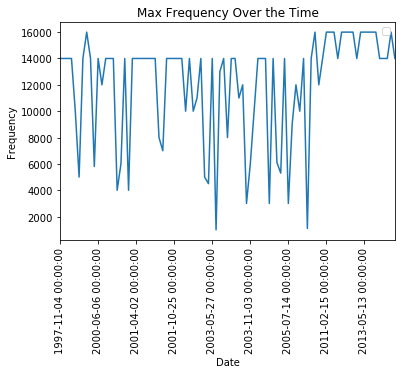

In [35]:
# plot start date vs frequency 
# this plot shows that start frequency has been increased in recent years 
%matplotlib inline
import matplotlib.pyplot as plt
df2 = df_NASA.loc[:,['start_date', 'start_frequency']]
df2.sort_values('start_date',ascending=[True], inplace=True)

#uses the index for the x values
df2 = df2.set_index('start_date')
# select number of columns you wish to plot 
num_cols = ['start_frequency']
df2[num_cols] = df2[num_cols].astype(float)

df2[num_cols].plot()
plt.xticks(rotation = 90)
plt.title('Max Frequency Over the Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend('')
plt.show()

This plot shows that start frequency has been increased in recent years

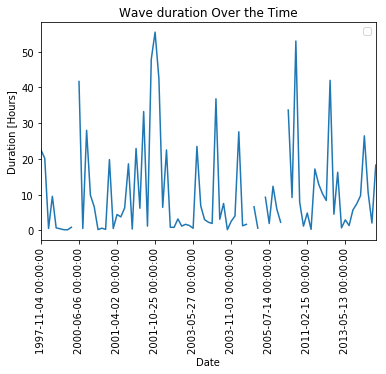

In [44]:
# Plot Wave duration for each incident 
# This plot shows Max duration happen in 2001-2002
# From 2002 to 2009 the Sun activity was relatively low 

import datetime as dt
df_NASA['Difference'] = (pd.to_datetime(df_NASA['end_datetime']) - pd.to_datetime(df_NASA['start_datetime'])) / np.timedelta64(1, 'h')
#print (type(df_NASA.iloc[0]['Difference']))
df_NASA['Difference'][df_NASA['Difference']< 0] = 0
df_NASA['Difference']= df_NASA['Difference'].replace(df_NASA['Difference']<0 , np.NaN)
df2 = df_NASA.loc[:,['start_date', 'Difference']]
df2.sort_values('start_date',ascending=[True], inplace=True)

#uses the index for the x values
df2 = df2.set_index('start_date')
# select number of columns you wish to plot 
num_cols = ['Difference']
df2[num_cols] = df2[num_cols].astype(float)

df2[num_cols].plot()
plt.xticks(rotation = 90)
plt.title('Wave duration Over the Time')
plt.xlabel('Date')
plt.ylabel('Duration [Hours]')
plt.legend('')
plt.show()

This plot shows Max duration happen in 2001-2002
From 2002 to 2009 the Sun activity was relatively low 